Elapsed 0.003999233245849609 seconds
Number of iterations 1
x_0 - x_b: 	[[0. 0. 0. 0. 0. 0.]]
(240,) (6, 240)


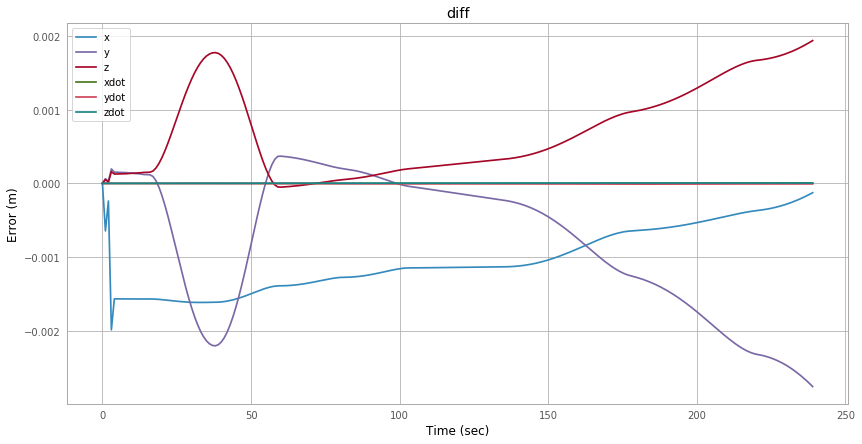

In [1]:
import time
import numpy as np

# Astropy 4.1rc1 is used
from astropy import units as u
from astropy.coordinates import EarthLocation, ITRS, ICRS, TEME, CartesianDifferential, CartesianRepresentation
from astropy.visualization import astropy_mpl_style
from astropy.time import Time

from scipy.integrate import odeint

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sgp4.api import Satrec, SGP4_ERRORS

from orbitdeterminator.doppler_determination.orbdet.utils.utils import *
from orbitdeterminator.doppler_determination.orbdet.utils.utils_aux import *
from orbitdeterminator.doppler_determination.orbdet.utils.utils_vis import *

np.set_printoptions(precision=4)
plt.style.use(astropy_mpl_style)
%matplotlib inline

f_downlink_falconsat = 435.103
tle_falconsat = [ '1 30776U 07006E   20146.24591950  .00002116  00000-0  57170-4 0  9998',
'2 30776  35.4350  68.4822 0003223 313.1473  46.8985 15.37715972733265']

epoch_start = Time('2020-05-27 23:46:00')
epoch_end = Time('2020-05-27 23:50:00')

#chilbolton = EarthLocation(lat=51.1483578*u.deg, lon=-1.4384458*u.deg, height=0.081*u.km)
site = EarthLocation(lat=33.7743331*u.deg, lon=-84.3970209*u.deg, height= 0.288*u.km)
site_itrs = site.get_itrs(obstime=epoch_start)

# Get satellite trajectory
e, r, v, jd, fr = get_satellite_sgp4(tle_falconsat, epoch_start, epoch_end, 1.0/86400.0)
t = Time(jd + fr, format='jd')

tt_datetime = t.to_datetime()
tt_sec = t.to_value('unix')
tt_sec -= tt_sec[0]

tt_sec_1 = np.arange(0, 240, 1)

nt = len(fr)

r_teme = CartesianRepresentation(r[:,0], r[:,1], r[:,2], unit=u.km)
v_teme = CartesianDifferential(v[:,0], v[:,1], v[:,2], unit=u.km/u.s)
teme = TEME(r_teme.with_differentials(v_teme), obstime=t)

itrs = teme.transform_to(ITRS(obstime=t))

x_obs = np.expand_dims(np.append(site_itrs.data.xyz.value, np.array([0,0,0])), axis=1)
x_obs = np.repeat(x_obs, nt, axis=1)*1e3
x_sat_temp = np.array([itrs.x.value, itrs.y.value, itrs.z.value, itrs.v_x.value, itrs.v_y.value, itrs.v_z.value])

x_orbdyn = np.transpose(odeint(orbdyn_2body, x_sat_temp[:,0]*1e3, tt_sec_1, args=(MU,)))
r, rr = range_range_rate(x_orbdyn, x_obs)

x_0 = np.expand_dims(x_sat_temp[:,0]*1e3, axis=1)

# Propagate in order to get range rate measurements
Phi_0 = np.eye(x_0.shape[0])
x_Phi_0 = np.concatenate([x_0.squeeze(), Phi_0.flatten()])
x_Phi = np.transpose(odeint(orbdyn_2body_stm, x_Phi_0, tt_sec_1, args=(MU,)))
x_sat_orbdyn_stm = x_Phi[0:6,]
Phi = x_Phi[6:,].reshape((x_0.shape[0], x_0.shape[0],  t.shape[0])) 

x_sat_orbdyn = np.transpose(odeint(orbdyn_2body, x_0.squeeze(), tt_sec_1, args=(MU,)))

diff = x_sat_orbdyn - x_sat_orbdyn_stm

r, rr = range_range_rate(x_sat_orbdyn_stm, x_obs)

P_bar_0 = np.eye(6)*1e-6
R = np.eye(1)*1e-6

time_start = time.time()

print

x_b, output = batch(
    x_0, 
    P_bar_0, 
    R, 
    np.expand_dims(rr,axis=0), 
    tt_sec_1, 
    x_obs, 
    f_obs=f_obs_range_rate, 
    tolerance=1e-8
)

print(f"Elapsed {time.time() - time_start} seconds")
print(f"Number of iterations", output['num_it'])
print(f"x_0 - x_b: \t{(x_0 - x_b).T}")

print(tt_sec_1.shape, diff.shape)

labels = ['x', 'y', 'z', 'xdot', 'ydot', 'zdot']

fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(111)
ax1.set_title('diff')
for d, label in zip(diff, labels):
    ax1.plot(tt_sec_1, d, label=label)
ax1.set_ylabel('Error (m)')
ax1.set_xlabel('Time (sec)')
ax1.legend()
